In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T

import math
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import torch.utils.data.dataloader as dataloader

In [2]:
batch_size = 128
num_epochs = 100
learning_rate = 1e-4
best_valid_acc = 0
data_set_root = "../../datasets"

In [3]:
start_from_checkpoint = False
save_dir = '../data/Models'
model_name = 'SelfALexNet'

In [4]:
gpu_indx=0
device=torch.device(gpu_indx if torch.cuda.is_available() else 'mps')

# Data Augmentation
về cái transform để phù hợp với data tôi tham khảo ở link [https://medium.com/@siddheshb008/alexnet-architecture-explained-b6240c528bd5](https://medium.com/@siddheshb008/alexnet-architecture-explained-b6240c528bd5)

In [6]:
train_transform =T.Compose([T.Resize(227),
                      T.ToTensor(),
                      T.RandomResizedCrop(size=(224, 224), antialias=True),
                      T.RandomHorizontalFlip(p=0.5),
                      T.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])

testval_transform =T.Compose([T.Resize(227),
                      T.ToTensor(),
                      T.RandomResizedCrop(size=(224, 224), antialias=True),
                      T.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])

In [7]:
# !pip install split-folders

In [8]:
import splitfolders
import os

In [9]:
path= "/Users/nguyenthephong/Desktop/Okay this is ML serious/Pytorch/SOme self implemented model practice/Vtuber"
print(os.listdir(path))

['.DS_Store', 'Suisei', 'Azki']


In [10]:
for folder in os.listdir(path):
    if not folder.startswith('.') and os.path.isdir(os.path.join(path,folder)):
        print(folder)

Suisei
Azki


In [11]:
splitfolders.ratio(path,seed=1337, output="Vtuber_splitted", ratio=(0.6, 0.2, 0.2)) #train, test, val wwill go to new folder in output

Copying files: 600 files [00:00, 1062.79 files/s]


In [12]:
print(os.getcwd())

/Users/nguyenthephong/Desktop/Okay this is ML serious/Pytorch/SOme self implemented model practice


In [13]:
from torchvision.datasets import ImageFolder
train= "/Users/nguyenthephong/Desktop/Okay this is ML serious/Pytorch/SOme self implemented model practice/Vtuber_splitted/train"
train_path= ImageFolder(root=train,transform=train_transform)
print(f'Number of training examples: {len(train_path)}')

Number of training examples: 360


In [14]:
test= "/Users/nguyenthephong/Desktop/Okay this is ML serious/Pytorch/SOme self implemented model practice/Vtuber_splitted/test"
test_path= ImageFolder(root=test,transform=testval_transform)
print(f'Number of examples: {len(test_path)}')
val= "/Users/nguyenthephong/Desktop/Okay this is ML serious/Pytorch/SOme self implemented model practice/Vtuber_splitted/val"
val_path= ImageFolder(root=val,transform=testval_transform)
print(f'Number of examples: {len(val_path)}')

Number of examples: 120
Number of examples: 120


In [15]:
train_loader = dataloader.DataLoader(train_path, shuffle=True, batch_size=batch_size)
test_loader = dataloader.DataLoader(test_path, batch_size=batch_size)
val_loader  = dataloader.DataLoader(val_path, batch_size=batch_size)

In [16]:
class SelfALexNet(nn.Module):
    def __init__(self, image_size_color,classes):
        super(SelfALexNet, self).__init__()
        self.conv1=nn.Conv2d(image_size_color, 96, kernel_size=11,stride=4,padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=3,stride=2)

        self.conv2=nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=3,stride=2)

        self.conv3=nn.Conv2d(256, 384, kernel_size=3,stride=1,padding=1)
        self.conv4=nn.Conv2d(384, 384, kernel_size=3,stride=1,padding=1)
        
        self.conv5=nn.Conv2d(384, 256, kernel_size=3,stride=1,padding=1)
        self.maxpool3=nn.MaxPool2d(kernel_size=3,stride=2)
        
        self.fc1=nn.Linear(9216,4096)
        self.fc2=nn.Linear(4096,4096)
        self.fc3=nn.Linear(4096,classes)
    def forward(self, x):
        x= F.relu(self.conv1(x))
        x= F.relu(self.maxpool1(x))
        x= F.relu(self.conv2(x))
        x= F.relu(self.maxpool2(x))
        x= F.relu(self.conv3(x))
        x= F.relu(self.conv4(x))
        x= F.relu(self.conv5(x))
        x= F.relu(self.maxpool3(x))
        x=torch.flatten(x, start_dim=1)
        x= F.relu(self.fc1(x))
        x= F.relu(self.fc2(x))
        x= F.softmax(self.fc3(x))
        return x

In [17]:
model=SelfALexNet(3,2)
model.to(device)
for parameter in model.parameters():
    print(parameter)

Parameter containing:
tensor([[[[ 4.1767e-02, -6.3834e-03, -2.4126e-02,  ..., -2.6562e-02,
            2.2173e-02,  1.1749e-02],
          [ 4.4575e-02,  1.1505e-02,  3.1286e-02,  ..., -1.6640e-02,
            4.6627e-02,  3.7213e-02],
          [-1.9813e-02, -1.0196e-02, -1.8124e-02,  ...,  4.9206e-02,
            3.7191e-02,  5.0816e-02],
          ...,
          [ 2.7644e-03, -2.0513e-02, -1.5651e-03,  ...,  4.9173e-02,
            3.9850e-02, -5.0607e-02],
          [-2.2285e-02,  9.6356e-03, -2.6189e-02,  ..., -3.4708e-02,
            5.9831e-04,  1.9942e-03],
          [-8.7978e-03, -2.0765e-02, -3.0950e-02,  ...,  2.5679e-02,
           -4.9030e-02,  3.2954e-02]],

         [[-5.2209e-02,  4.2326e-02, -2.9888e-02,  ...,  3.3538e-02,
            2.8288e-02,  2.2458e-02],
          [-2.3423e-02,  3.6088e-02,  2.8362e-02,  ..., -2.5551e-02,
            1.8605e-03,  9.6472e-03],
          [ 1.9955e-02, -4.8288e-02,  5.0691e-02,  ...,  1.9489e-02,
           -2.9721e-02,  3.4199e-02]

In [18]:
num_params = 0
for param in model.parameters():
    num_params += param.flatten().shape[0]
print("This model has %d (approximately %d Million) Parameters!" % (num_params, num_params//1e6))

This model has 58289538 (approximately 58 Million) Parameters!


In [19]:
# Create a dataloader itterable object
dataiter = iter(test_loader)
# Sample from the itterable object
test_images, test_labels = next(dataiter)

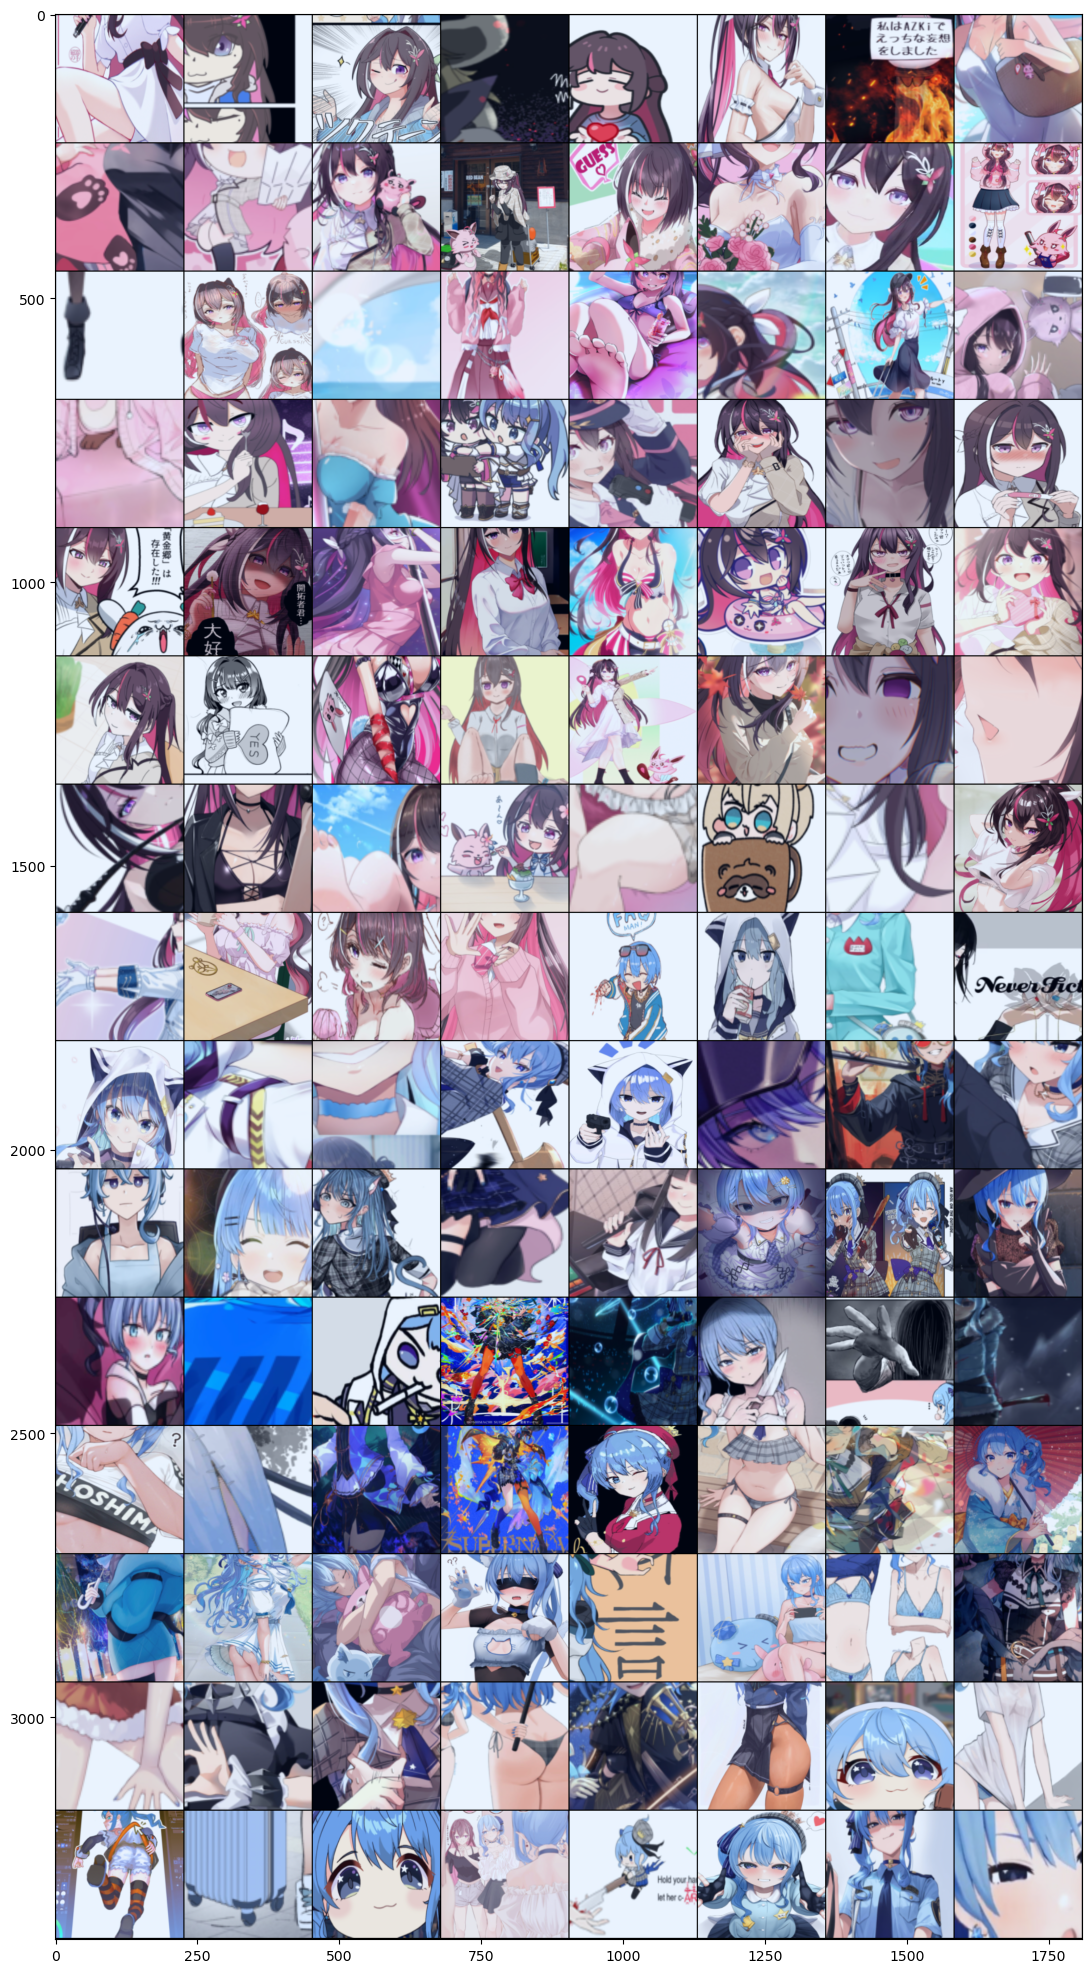

In [20]:
plt.figure(figsize = (50,25))
out = torchvision.utils.make_grid(test_images, 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

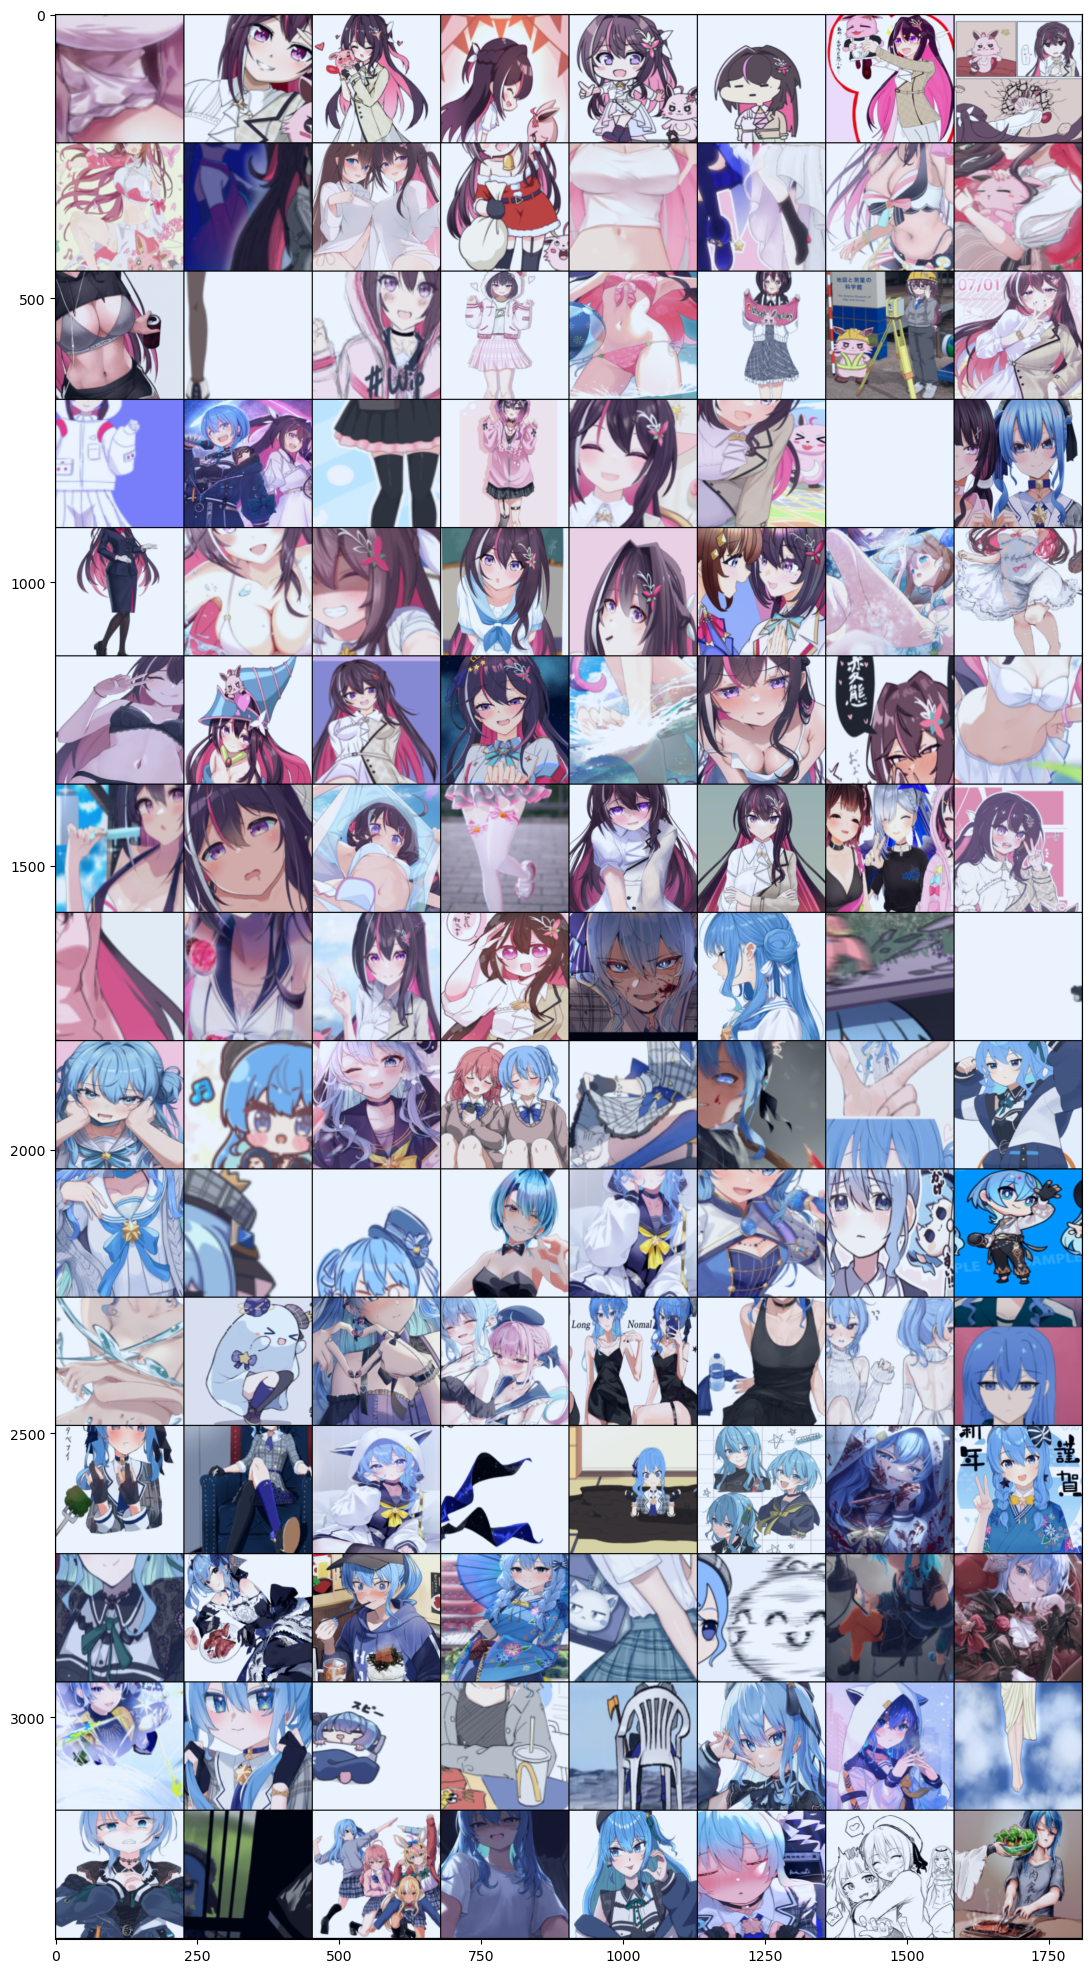

In [21]:
val_dataiter = iter(val_loader)
val_images, val_labels = next(val_dataiter)

plt.figure(figsize = (50,25))
out_val = torchvision.utils.make_grid(val_images, 8, normalize=True)
plt.imshow(out_val.numpy().transpose((1, 2, 0)))

In [22]:
loss_fun = nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(model.parameters(), lr=learning_rate)

wrong_train_storage =[]
wrong_test_storage =[]
wrong_val_storage =[]

In [23]:
for epoch in trange(num_epochs, leave=False, desc="Epoch"):
    model.train()
    optimizer.zero_grad()
    for i, (x, y) in enumerate(tqdm(train_loader, leave=False, desc="Training")):
        fx = model(x.to(device))
        loss = loss_fun(fx, y.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        wrong_train_storage.append(loss.item())

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/84/wvnn9yns4ns67p0snf1b9rcr0000gn/T/ipykernel_46505/2628287290.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x= F.softmax(self.fc3(x))


Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

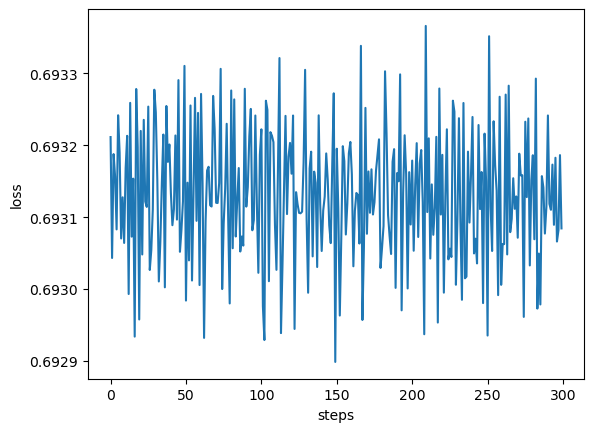

In [24]:
plt.plot(wrong_train_storage)
plt.xlabel("steps")
plt.ylabel("loss")
plt.show()